In [83]:
import numpy as np
import cv2
from tqdm import tqdm
import time
from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [84]:
print("CUDA Available:", tf.config.list_physical_devices('GPU'))

CUDA Available: []


In [85]:
@tf.function(jit_compile=True)
def add_gaussian_noise(image, mean=0, sigma=25):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=sigma, dtype=tf.float32)
    noisy_image = tf.clip_by_value(image + noise, 0, 255)
    return tf.cast(noisy_image, tf.uint8)


In [86]:
def get_window(img, x, y, size):
    half_size = size // 2
    return img[y - half_size:y + half_size + 1, x - half_size:x + half_size + 1]

In [1]:
def NL_means(img, h=8.5, f=4, t=11):
    N = 2 * f + 1
    S = 2 * t + 1
    sigma_h = h
    pad_img = np.pad(img, t + f)
    h, w = img.shape

    neigh_mat = np.zeros((h + S - 1, w + S - 1, N, N))

    for y in range(h + S - 1):
        for x in range(w + S - 1):
            neigh_mat[y, x] = np.squeeze(get_window(pad_img[:, :, np.newaxis], x + f, y + f, 2 * f + 1))

    output = np.zeros(img.shape)
    prog = tqdm(total=(h - 1) * (w - 1), position=0, leave=True)

    for Y in range(h):
        for X in range(w):
            x = X + t
            y = Y + t
            a = get_window(neigh_mat.reshape((h + S - 1, w + S - 1, N * N)), x, y, S)
            b = neigh_mat[y, x].flatten()
            c = a - b
            d = c * c
            e = np.sqrt(np.sum(d, axis=2))
            F = np.exp(-e / (sigma_h * sigma_h))
            Z = np.sum(F)

            im_part = np.squeeze(get_window(pad_img[:, :, None], x + f, y + f, S))
            NL = np.sum(F * im_part)
            output[Y, X] = NL / Z
            prog.update(1)

    return output

In [2]:
def process_image_cpu(image):
    noisy_img = add_gaussian_noise(image)

    with tf.device('/CPU:0'):
        start_time_cpu = time.time()
        denoised_cpu = NL_means(noisy_img, h=9, f=4, t=12)
        cpu_time = time.time() - start_time_cpu

    return noisy_img, denoised_cpu, cpu_time

In [3]:
def display_results(original, noisy, denoised, title="Results"):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Noisy Image")
    plt.imshow(noisy, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Denoised Image")
    plt.imshow(denoised, cmap='gray')
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

In [4]:
def print_timings(cpu_time=None, gpu_time=None):
    if cpu_time is not None:
        print(f'CPU Time: {cpu_time:.4f} seconds')
    if gpu_time is not None:
        print(f'GPU Time: {gpu_time:.4f} seconds')


In [103]:
uploaded_files = files.upload()


Saving bird.jpg to bird (4).jpg
Saving vegetables.jpg to vegetables (4).jpg
Saving woman.jpg to woman (20).jpg


Processing bird (4).jpg...


157609it [00:38, 4140.73it/s]


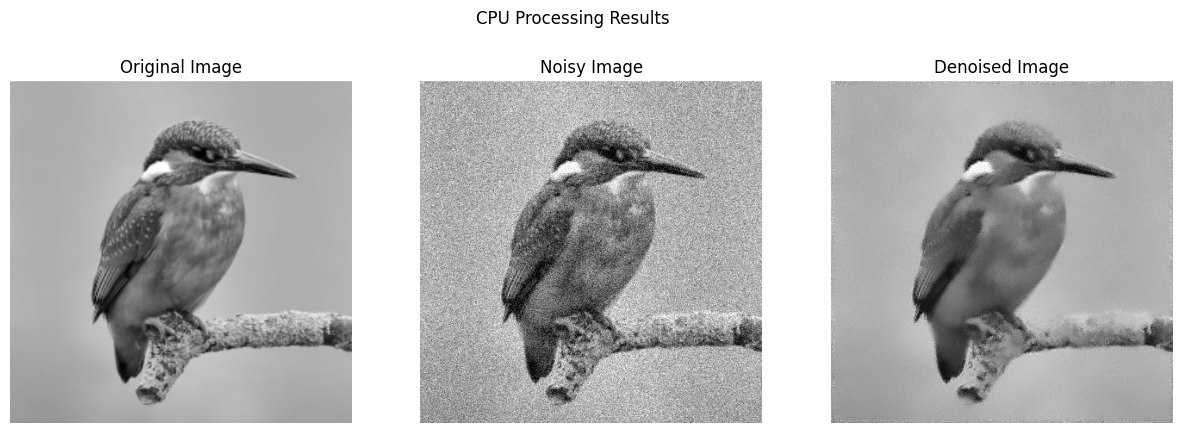

CPU Time: 38.4749 seconds
Processing vegetables (4).jpg...


192153it [00:48, 3990.67it/s]


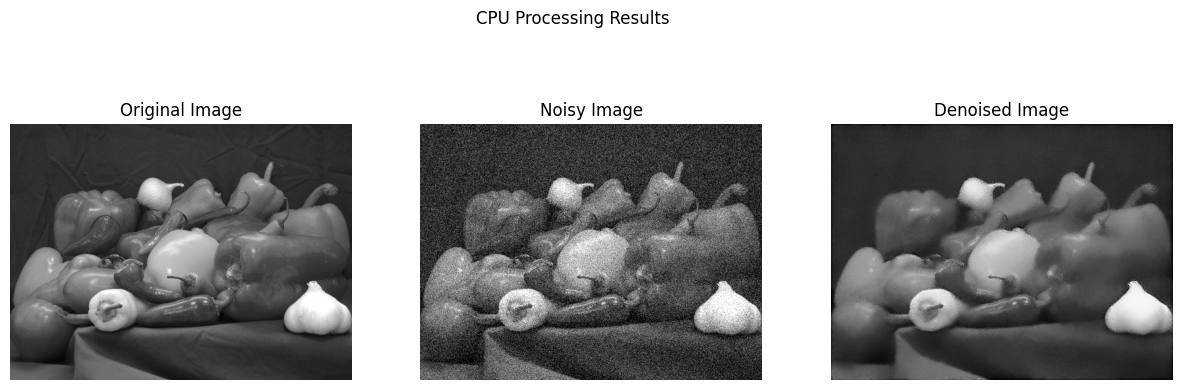

CPU Time: 48.8656 seconds
Processing woman (20).jpg...


50625it [00:12, 4010.23it/s]


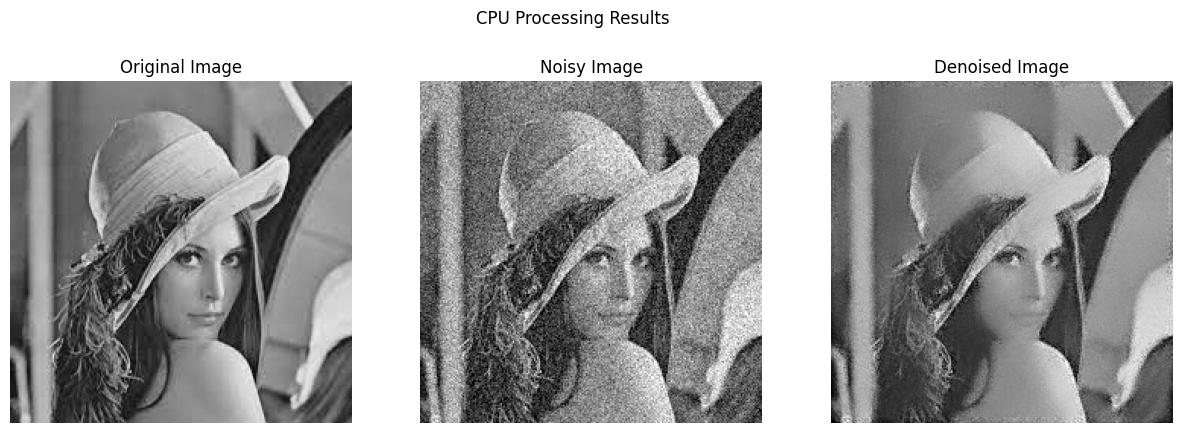

CPU Time: 12.8008 seconds


In [114]:

for filename, file_data in uploaded_files.items():
    print(f'Processing {filename}...')

    img = Image.open(BytesIO(file_data)).convert('L')
    img = np.array(img, dtype=np.float32)

    # For CPU Processing
    noisy_cpu, denoised_cpu, cpu_time = process_image_cpu(img)
    display_results(img, noisy_cpu, denoised_cpu, title="CPU Processing Results")
    print_timings(cpu_time=cpu_time)



In [5]:
def process_image_gpu(image):
    image_float32 = tf.convert_to_tensor(image, dtype=tf.float32)

    noisy_img = add_gaussian_noise(image_float32)

    def wrapped_NL_means(noisy_img_np):
        return NL_means(noisy_img_np).astype(np.float32)

    with tf.device('/GPU:0'):
        start_time_gpu = time.time()
        denoised_gpu = tf.numpy_function(
            wrapped_NL_means, [noisy_img.numpy()], tf.float32
        )
        gpu_time = time.time() - start_time_gpu

    return noisy_img, denoised_gpu, gpu_time

Processing bird (4).jpg...


157609it [00:32, 4882.05it/s]


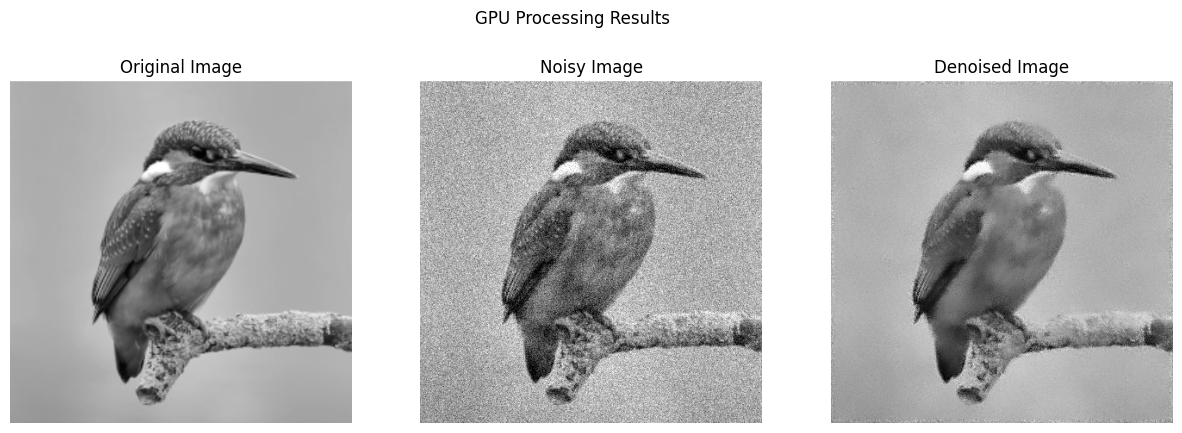

GPU Time: 32.7007 seconds
Processing vegetables (4).jpg...


192153it [00:40, 4767.98it/s]


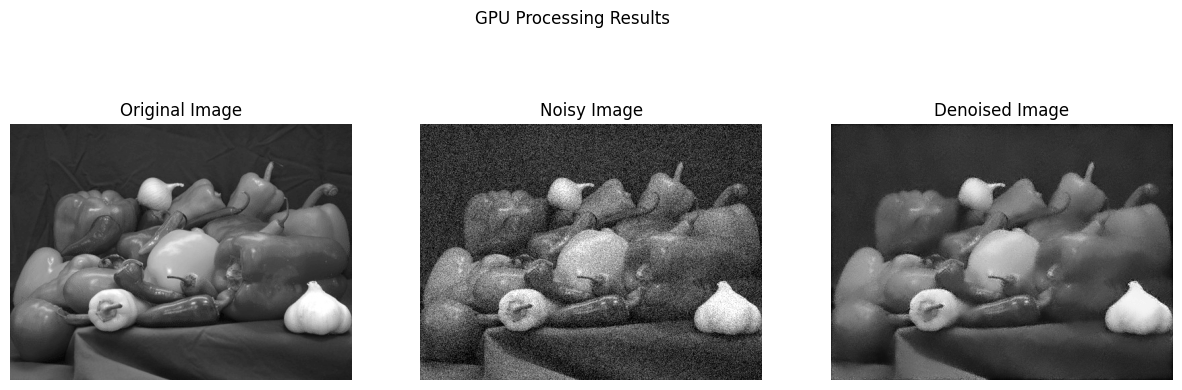

GPU Time: 40.9370 seconds
Processing woman (20).jpg...


50625it [00:10, 4719.78it/s]                           


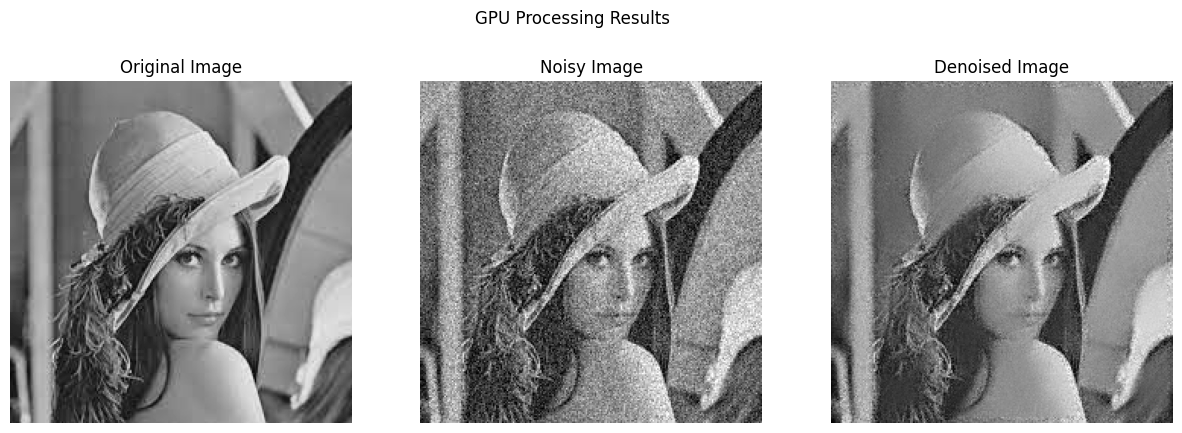

GPU Time: 10.9482 seconds


In [115]:
for filename, file_data in uploaded_files.items():
    print(f'Processing {filename}...')

    img = Image.open(BytesIO(file_data)).convert('L')
    img = np.array(img)
    noisy_gpu, denoised_gpu, gpu_time = process_image_gpu(img)

    display_results(img, noisy_gpu, denoised_gpu, title="GPU Processing Results")
    print_timings(gpu_time=gpu_time)
